<a href="https://colab.research.google.com/github/Comfortxble/UROP-ABCD/blob/main/LogReg_rsfMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load Packages**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/vir_env/lib/python3.13/site-packages")

In [3]:
#Loading other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, RocCurveDisplay

### **Helper Function for Metrics**

In [4]:
def specicivity(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return tn / (tn + fp)

In [5]:
def sensitivity(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return tp / (tp + fn)

In [6]:
auc_list =[]
def store_auc(X, y_test, label, model):
  y_proba = model.predict_proba(X)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_proba)
  auc_list.append([fpr, tpr, label, auc(fpr, tpr)])

In [7]:
def auc_compare_plot(auc_list):
  plt.figure(figsize=(10, 6))

  for list in auc_list:
    fpr = list[0]
    tpr = list[1]
    label = list[2]
    auc_value = list[3]
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_value:.2f})')

  plt.plot([0, 1], [0, 1], 'k--', label='Chance')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')
  plt.legend()
  plt.grid(True)
  plt.show()

In [8]:
def get_metrics(X, y, model):
  y_pred = model.predict(X)
  y_proba = model.predict_proba(X)[:,1]
  print(classification_report(y, y_pred))
  print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
  print(f"Recall: {recall_score(y, y_pred):.4f}")
  print(f"Sensitivity: {sensitivity(y, y_pred):.4f}")
  print(f"Specificity: {specicivity(y, y_pred):.4f}")
  print(f"AUC: {roc_auc_score(y, y_proba):.4f}")
  print(f"Average Precision: {average_precision_score(y, y_proba):.4f}")

In [9]:
def iteration_helper(c_values):
  for c in c_values:
    log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                                penalty='l1', solver='liblinear', C=c)
    log_reg = log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_proba_v = log_reg.predict_proba(X_valid)[:,1]
    y_proba_t = log_reg.predict_proba(X_test)[:,1]

    recall.append(recall_score(y_test, y_pred))
    auc_valid.append(roc_auc_score(y_valid, y_proba_v))
    auc_test.append(roc_auc_score(y_test, y_proba_t))
    auprc.append(average_precision_score(y_test, y_proba_t))

## **Load Data + Data Separation**

In [10]:
df = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_rsfMRI_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_rsfMRI_test.csv")

In [11]:
y = df['SuicideAttempt']
X = df.drop(['SuicideAttempt', 'subjectkey'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
# stratify=y to mediate data imbalance

y_test = df_test['SuicideAttempt']
X_test = df_test.drop(['SuicideAttempt', 'subjectkey'], axis=1)

In [12]:
# Questionaire ONLY
X_train_q = X_train.iloc[:, 0:130]
X_valid_q = X_valid.iloc[:, 0:130]
X_test_q = X_test.iloc[:, 0:130]

# fMRI ONLY
X_train_mri = X_train.iloc[:, 130::]
X_valid_mri = X_valid.iloc[:, 130::]
X_test_mri = X_test.iloc[:, 130::]

## **Preliminary Model**

In [ ]:
clf_model = LogisticRegression(random_state=1, class_weight='balanced',
                             n_jobs=-1, max_iter=2500)
log_reg_pre = clf_model.fit(X_train, y_train)

get_metrics(X_valid, y_valid, log_reg_pre)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1293
           1       0.00      0.00      0.00         9

    accuracy                           0.94      1302
   macro avg       0.50      0.47      0.48      1302
weighted avg       0.99      0.94      0.96      1302

Accuracy: 0.9378
Recall: 0.0000
Sensitivity: 0.0000
Specificity: 0.9443
AUC: 0.6306
Average Precision: 0.0117


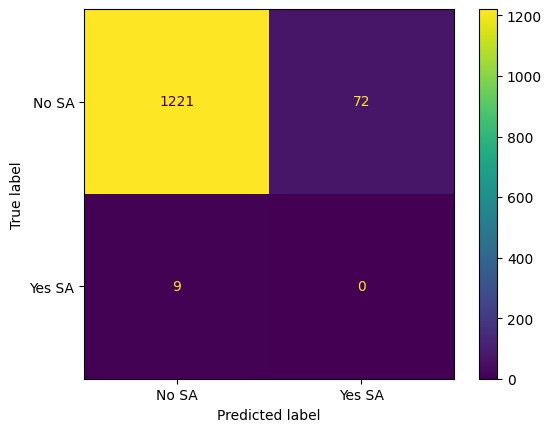

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg_pre, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

In [ ]:
test_predict = log_reg_pre.predict(X_test)
test_predict_proba = log_reg_pre.predict_proba(X_test)[:,1]

get_metrics(X_test, y_test, log_reg_pre)

              precision    recall  f1-score   support

           0       0.50      0.90      0.64        10
           1       0.67      0.18      0.29        11

    accuracy                           0.52        21
   macro avg       0.58      0.54      0.46        21
weighted avg       0.59      0.52      0.46        21

Accuracy: 0.5238
Recall: 0.1818
Sensitivity: 0.1818
Specificity: 0.9000
AUC: 0.5636
Average Precision: 0.6781


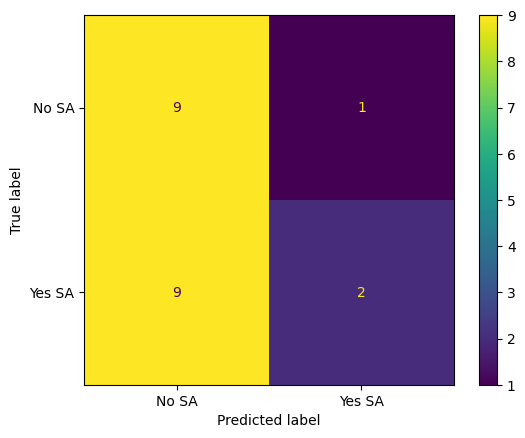

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg_pre, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

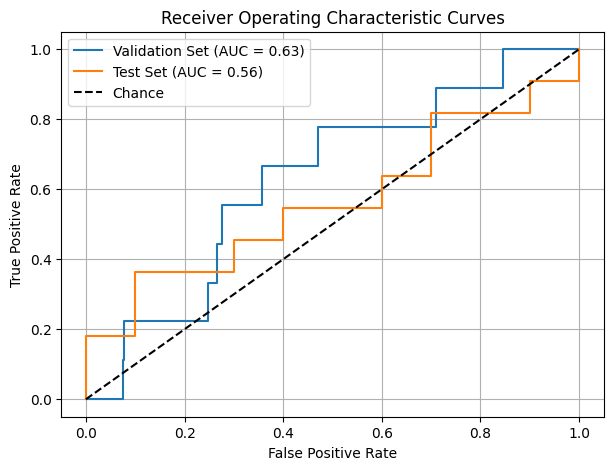

In [ ]:
predict_proba_v = log_reg_pre.predict_proba(X_valid)
predict_proba_t = log_reg_pre.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr0, tpr0, thresholds0 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc0 = auc(fpr0, tpr0)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr0, tpr0, label=f'Test Set (AUC = {auc0:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance

In [ ]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg_pre.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance.head(5)

,Feature,Coefficient,Odds Ratio
62,weight,3.087266,21.917084
95,TotProb.CBCL,2.547665,12.777238
4,race.ethnicity_4,2.418256,11.226262
14,high.educ_7,1.974209,7.200923
12,high.educ_5,1.967357,7.151749


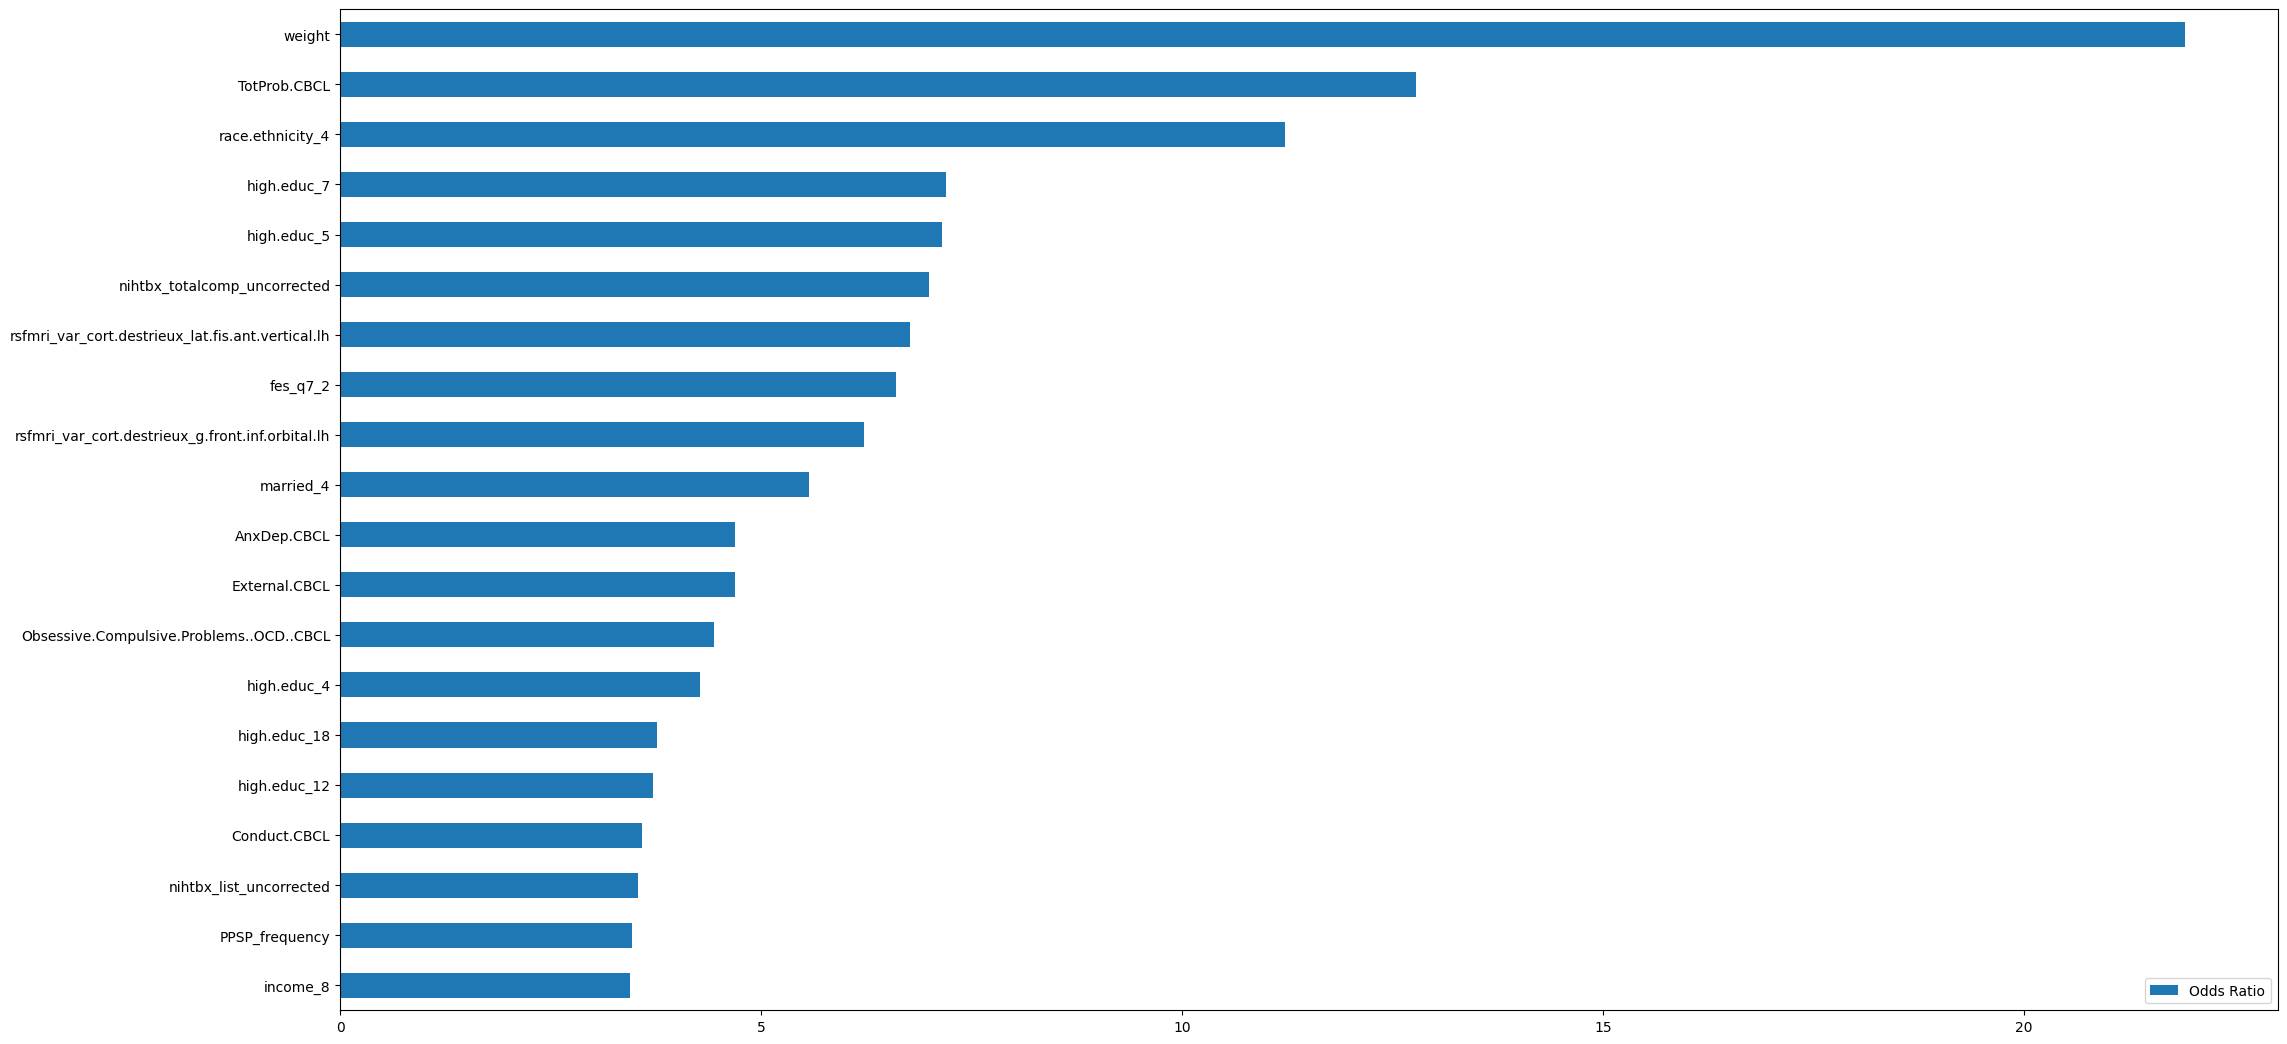

In [ ]:
feature_odds = pd.DataFrame(odds_ratios, index=feature_names,
                            columns=['Odds Ratio'])
feature_odds = feature_odds.sort_values(by='Odds Ratio', ascending=False)
FI_plot = feature_odds.head(20).plot(figsize=(25,13), kind='barh').invert_yaxis()

## **Model Optimization**

### **Iteration of Param_C**

#### 0 to 1 (step size = 0.001)

In [ ]:
c_values = np.arange(0.000000001, 1, 0.001) # run-time was 1 hr 17 m

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

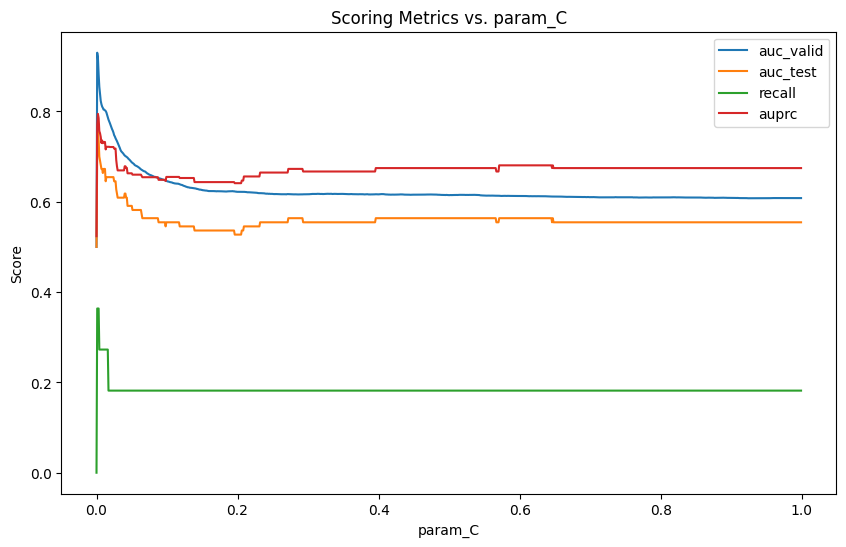

In [ ]:
metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['auc_test'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
2,0.002,0.918965,0.754545,0.363636,0.794636
3,0.003,0.882874,0.736364,0.363636,0.785416
1,0.001,0.930051,0.709091,0.363636,0.769705
4,0.004,0.854688,0.700000,0.272727,0.756470
5,0.005,0.837845,0.690909,0.272727,0.751649


#### 0 to 0.01 (step size = 0.00001)

In [ ]:
c_values = np.arange(0.000000001, 0.01, 0.00001) # run-time was 4min

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

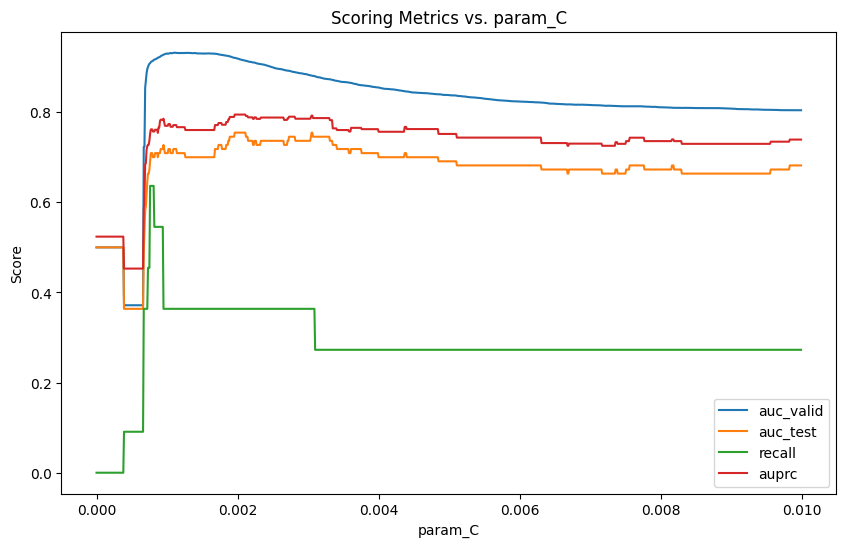

In [ ]:
metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['auc_test'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
205,0.00205,0.916301,0.754545,0.363636,0.794636
209,0.00209,0.915012,0.754545,0.363636,0.794636
207,0.00207,0.915872,0.754545,0.363636,0.794636
206,0.00206,0.916130,0.754545,0.363636,0.794636
210,0.00210,0.914669,0.754545,0.363636,0.794636


In [ ]:
metrics_df.sort_values(by=['recall'], ascending=False).head(10)

,param_C,auc_valid,auc_test,recall,auprc
76,0.00076,0.908739,0.690909,0.636364,0.752056
77,0.00077,0.910974,0.709091,0.636364,0.761759
78,0.00078,0.912606,0.709091,0.636364,0.761759
79,0.00079,0.913036,0.709091,0.636364,0.761759
80,0.00080,0.913895,0.700000,0.636364,0.757097
81,0.00081,0.915786,0.700000,0.636364,0.757097
82,0.00082,0.916645,0.700000,0.545455,0.757097
91,0.00091,0.924293,0.718182,0.545455,0.783253
93,0.00093,0.926098,0.718182,0.545455,0.783253
92,0.00092,0.925153,0.718182,0.545455,0.783253


#### 7e-4 to 0.0022 (step size = 1e-7)

In [ ]:
c_values = np.arange(0.0007, 0.0022, 0.0000001) # run-time was 1h

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

In [ ]:
mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

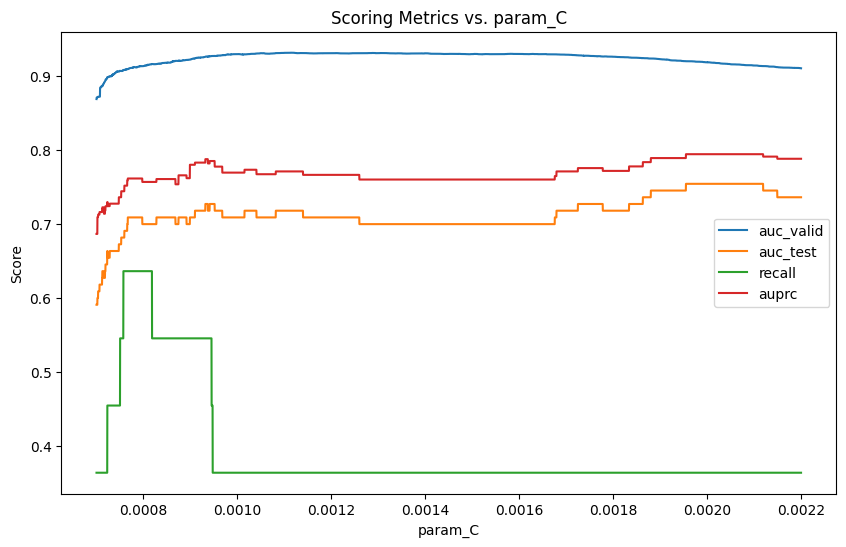

In [ ]:
metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['auc_test'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
12845,0.001984,0.919825,0.754545,0.363636,0.794636
12844,0.001984,0.919825,0.754545,0.363636,0.794636
13756,0.002076,0.915442,0.754545,0.363636,0.794636
13755,0.002075,0.915442,0.754545,0.363636,0.794636
13754,0.002075,0.915442,0.754545,0.363636,0.794636


In [ ]:
metrics_df.sort_values(by=['recall'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
764,0.000776,0.911489,0.709091,0.636364,0.761759
643,0.000764,0.909513,0.690909,0.636364,0.752056
631,0.000763,0.909083,0.690909,0.636364,0.752056
632,0.000763,0.909083,0.690909,0.636364,0.752056
633,0.000763,0.909083,0.690909,0.636364,0.752056


In [ ]:
metrics_df.sort_values(by=['auprc'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
13414,0.002041,0.916989,0.754545,0.363636,0.794636,0.707452
13044,0.002004,0.918879,0.754545,0.363636,0.794636,0.707924
13074,0.002007,0.918622,0.754545,0.363636,0.794636,0.707860
13075,0.002007,0.918622,0.754545,0.363636,0.794636,0.707860
13076,0.002008,0.918622,0.754545,0.363636,0.794636,0.707860


In [ ]:
metrics_df.sort_values(by=['mean'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
951,0.000795,0.913895,0.709091,0.636364,0.761759,0.755277
950,0.000795,0.913895,0.709091,0.636364,0.761759,0.755277
952,0.000795,0.913895,0.709091,0.636364,0.761759,0.755277
953,0.000795,0.913895,0.709091,0.636364,0.761759,0.755277
954,0.000795,0.913895,0.709091,0.636364,0.761759,0.755277


### **2nd Round Testing**

#### 0.00198 - 0.00208 (best auc_test)

In [ ]:
c_values = np.arange(0.00198, 0.00208, 0.000001) # run-time was 30s

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

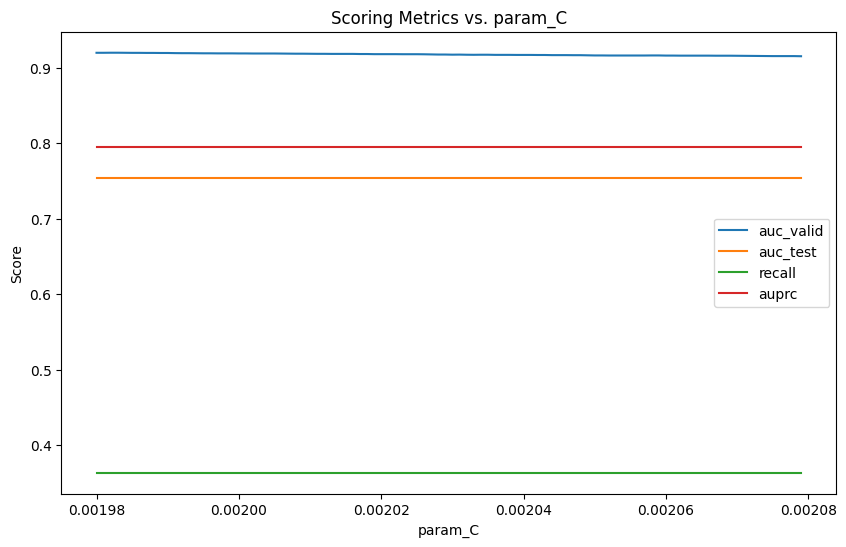

In [ ]:
mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['mean'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
2,0.001982,0.919911,0.754545,0.363636,0.794636,0.708182
3,0.001983,0.919911,0.754545,0.363636,0.794636,0.708182
0,0.001980,0.919825,0.754545,0.363636,0.794636,0.708161
4,0.001984,0.919825,0.754545,0.363636,0.794636,0.708161
1,0.001981,0.919825,0.754545,0.363636,0.794636,0.708161


For best auc_test AND recall, try 0.00198, 2043, 2053. For best mean, 0.001982, 1983, 1980.

#### 0.00076 - 0.00078 (best recall)

In [ ]:
c_values = np.arange(0.000760, 0.000780, 0.000001) # run-time was 3s

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

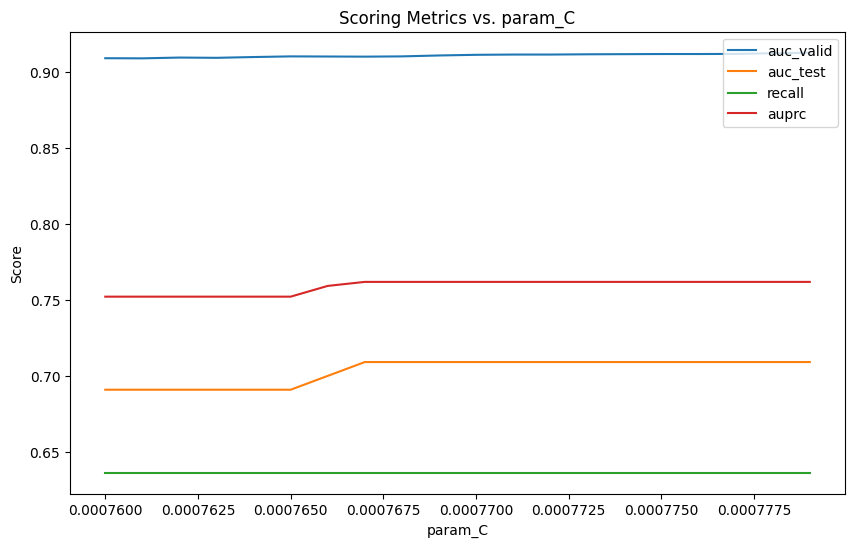

In [ ]:
mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['mean'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
19,0.000779,0.912349,0.709091,0.636364,0.761759,0.754890
18,0.000778,0.912005,0.709091,0.636364,0.761759,0.754804
17,0.000777,0.911575,0.709091,0.636364,0.761759,0.754697
16,0.000776,0.911489,0.709091,0.636364,0.761759,0.754676
15,0.000775,0.911489,0.709091,0.636364,0.761759,0.754676


For best auc_test and auprc, try 0.000770, 771, 778, 777. For best recall, try 0.000760, 761 (it's then followed by 778 and 777). For best mean, try 779, 778, 777.

#### 0.002 - 0.002045 (best auprc)

In [ ]:
c_values = np.arange(0.002, 0.002045, 0.000001) # run-time was 6s

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

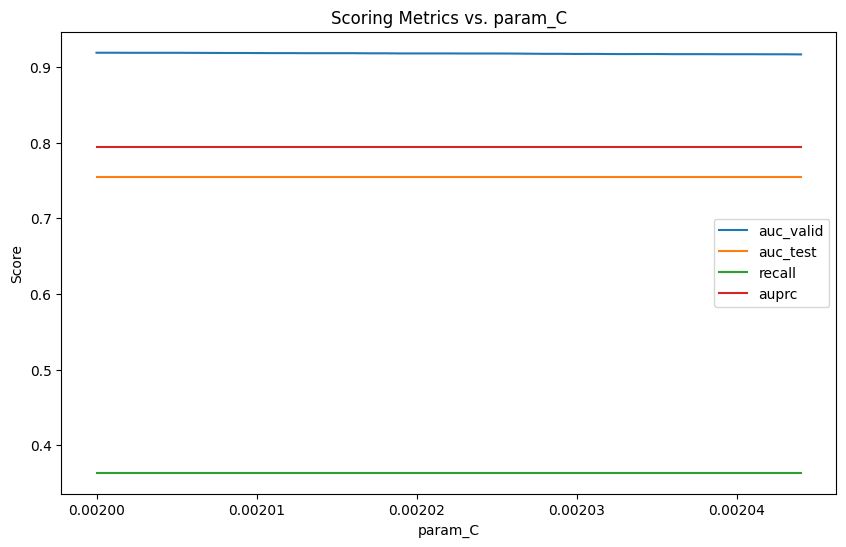

In [ ]:
mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['mean'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
0,0.002000,0.918965,0.754545,0.363636,0.794636,0.707946
1,0.002001,0.918965,0.754545,0.363636,0.794636,0.707946
2,0.002002,0.918879,0.754545,0.363636,0.794636,0.707924
3,0.002003,0.918879,0.754545,0.363636,0.794636,0.707924
4,0.002004,0.918879,0.754545,0.363636,0.794636,0.707924


For best mean, 0.002, 2001, 2002.
For best recall, auprc, AND auc_test, 0.002, 2023, 2025

#### 0.000785 - 0.000800 (best mean)

In [ ]:
c_values = np.arange(0.000785, 0.000800, 0.000001) # run-time was 2s

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

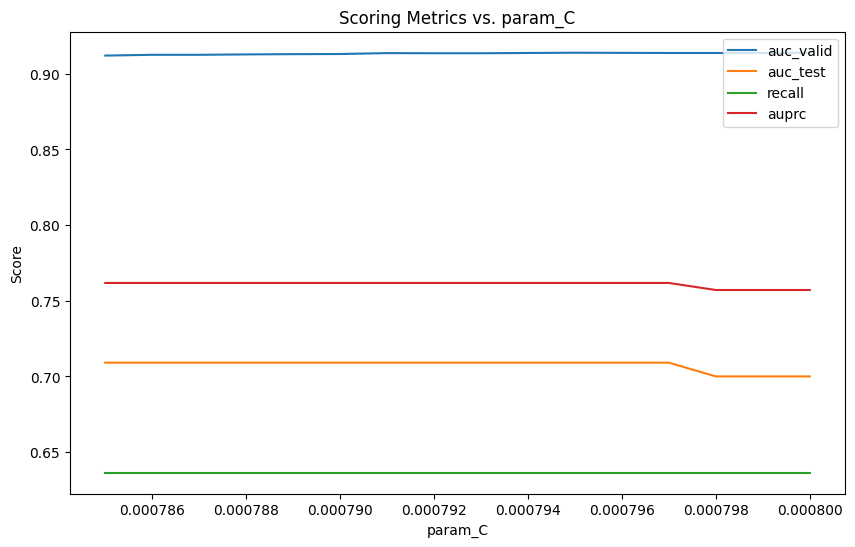

In [ ]:
mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['mean'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
10,0.000795,0.913895,0.709091,0.636364,0.761759,0.755277
11,0.000796,0.913809,0.709091,0.636364,0.761759,0.755256
9,0.000794,0.913723,0.709091,0.636364,0.761759,0.755234
12,0.000797,0.913723,0.709091,0.636364,0.761759,0.755234
6,0.000791,0.913638,0.709091,0.636364,0.761759,0.755213


For best mean, 0.000795, 796, 794.
For best recall, auprc, AND auc_test, 785, 786, 787.

### **3rd Round Testing**

What to test:


*   For best auc_test AND recall, try 0.00198, 2043, 2053. For best mean, 0.001982, 1983, 1980.

*   For best auc_test and auprc, try 0.000770, 771, 778, 777. For best recall, try 0.000760, 761 (it's then followed by 778 and 777). For best mean, try 779, 778, 777.

*   For best mean, 0.002, 2001, 2002.
For best recall, auprc, AND auc_test, 0.002, 2023, 2025

*   For best mean, 0.000795, 796, 794.
For best recall, auprc, AND auc_test, 785, 786, 787.



In [13]:
c_values = sorted([0.00198, 0.002043, 0.002053, 0.001982, 0.001983,
            0.00077, 0.000771, 0.000778, 0.000777, 0.00076, 0.000761, 0.000779,
            0.002, 0.002001, 0.002002, 0.002023, 0.002025,
            0.000795, 0.000796, 0.000794, 0.000785, 0.000786, 0.000787])

# print(c_values)

c_values_1 = [0.00076, 0.000761, 0.00077, 0.000771, 0.000777, 0.000778, 0.000779,
              0.000785, 0.000786, 0.000787, 0.000794, 0.000795, 0.000796]
c_values_2 = [0.00198, 0.001982, 0.001983, 0.002, 0.002001, 0.002002, 0.002023, 0.002025, 0.002043, 0.002053]

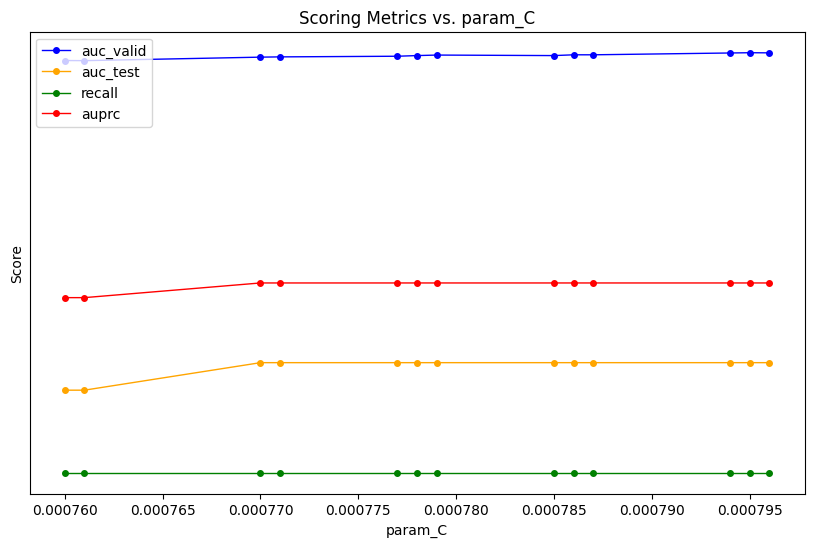

In [16]:
recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values_1)

mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df_1 = pd.DataFrame({'param_C': c_values_1, 'auc_valid': auc_valid,
                           'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red']

for i in range(len(metrics)):
    ax.plot(metrics_df_1['param_C'], metrics_df_1[metrics[i]], color=colors[i],
            marker='o', linewidth=1, markersize=4, label=metrics[i])

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_yticks([])
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

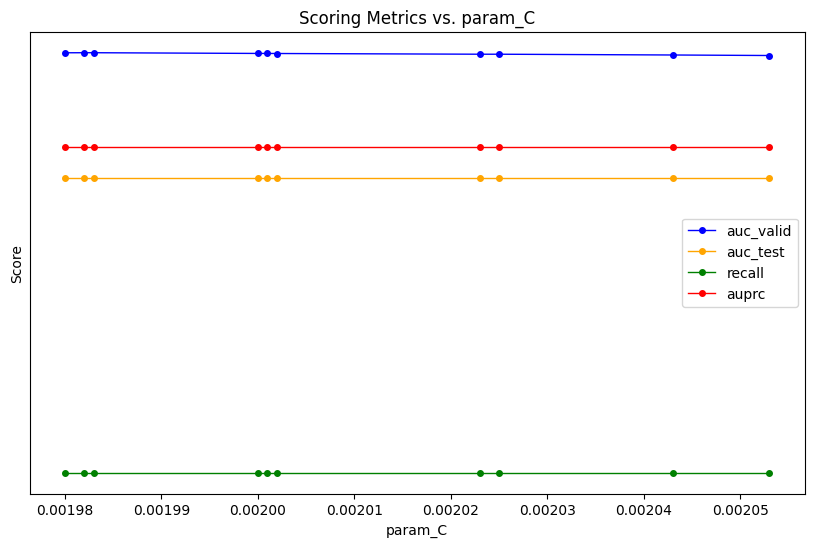

In [17]:
recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values_2)

mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df_2 = pd.DataFrame({'param_C': c_values_2, 'auc_valid': auc_valid,
                           'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red']

for i in range(len(metrics)):
    ax.plot(metrics_df_2['param_C'], metrics_df_2[metrics[i]], color=colors[i],
            marker='o', linewidth=1, markersize=4, label=metrics[i])

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_yticks([])
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df = pd.concat([metrics_df_1, metrics_df_2], axis=0)
metrics_df.sort_values(by=['mean'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
11,0.000795,0.913895,0.709091,0.636364,0.761759,0.755277
12,0.000796,0.913809,0.709091,0.636364,0.761759,0.755256
10,0.000794,0.913723,0.709091,0.636364,0.761759,0.755234
8,0.000786,0.912520,0.709091,0.636364,0.761759,0.754933
9,0.000787,0.912520,0.709091,0.636364,0.761759,0.754933


*   For best auc_test + auprc, 0.002053, 0.002043, 0.002025
*   For best recall, 0.00076, 0.000785, 0.000796
*   For best mean, 0.000795, 0.000796, 0.000794

## **Trials**


*   For best auc_test + auprc, 0.002053, 0.002043, 0.002025
*   For best recall, 0.00076, 0.000785, 0.000796
*   For best mean, 0.000795, 0.000796, 0.000794

### Best auc_test + auprc: 0.002053, 0.002043, 0.002025

In [20]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                            penalty='l1', solver='liblinear',
                            C=0.002025)
log_reg1 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg1)
get_metrics(X_test, y_test, log_reg1)

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      1293
           1       0.02      1.00      0.05         9

    accuracy                           0.73      1302
   macro avg       0.51      0.86      0.44      1302
weighted avg       0.99      0.73      0.84      1302

Accuracy: 0.7281
Recall: 1.0000
Sensitivity: 1.0000
Specificity: 0.7262
AUC: 0.9179
Average Precision: 0.0956
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.80      0.36      0.50        11

    accuracy                           0.62        21
   macro avg       0.68      0.63      0.60        21
weighted avg       0.69      0.62      0.59        21

Accuracy: 0.6190
Recall: 0.3636
Sensitivity: 0.3636
Specificity: 0.9000
AUC: 0.7545
Average Precision: 0.7946


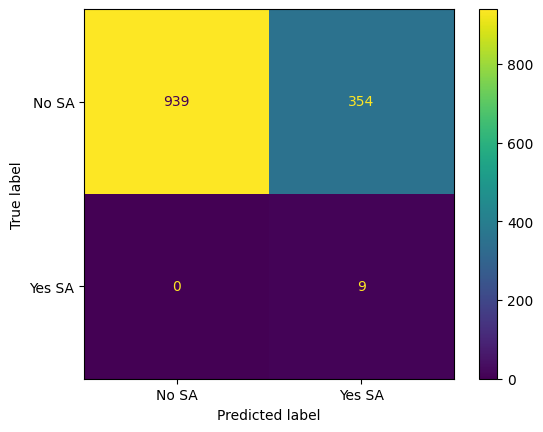

In [21]:
ConfusionMatrixDisplay.from_estimator(log_reg1, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

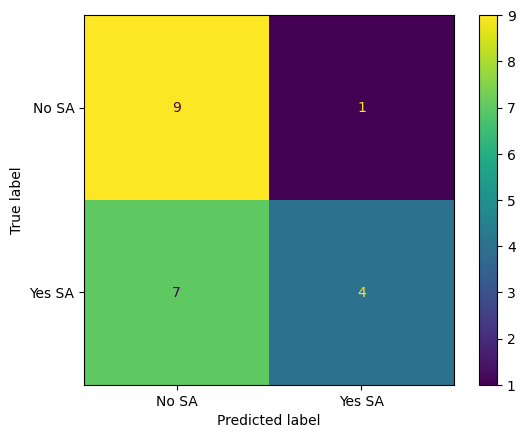

In [22]:
ConfusionMatrixDisplay.from_estimator(log_reg1, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

### Best recall: 0.00076, 0.000785, 0.000796

In [23]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                            penalty='l1', solver='liblinear',
                            C=0.000796)
log_reg2 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg2)
get_metrics(X_test, y_test, log_reg2)

              precision    recall  f1-score   support

           0       1.00      0.63      0.77      1293
           1       0.02      1.00      0.04         9

    accuracy                           0.63      1302
   macro avg       0.51      0.82      0.41      1302
weighted avg       0.99      0.63      0.77      1302

Accuracy: 0.6336
Recall: 1.0000
Sensitivity: 1.0000
Specificity: 0.6311
AUC: 0.9138
Average Precision: 0.0730
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.78      0.64      0.70        11

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.72      0.71      0.71        21

Accuracy: 0.7143
Recall: 0.6364
Sensitivity: 0.6364
Specificity: 0.8000
AUC: 0.7091
Average Precision: 0.7618


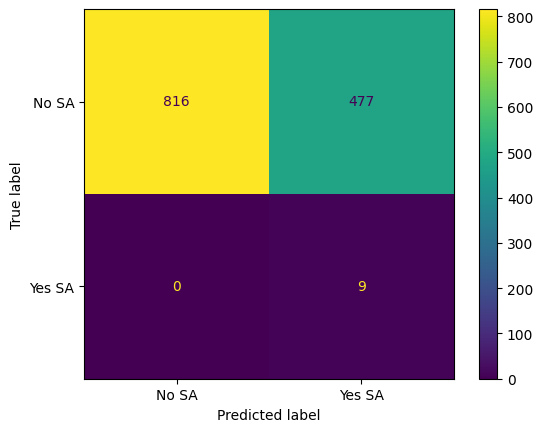

In [24]:
ConfusionMatrixDisplay.from_estimator(log_reg2, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

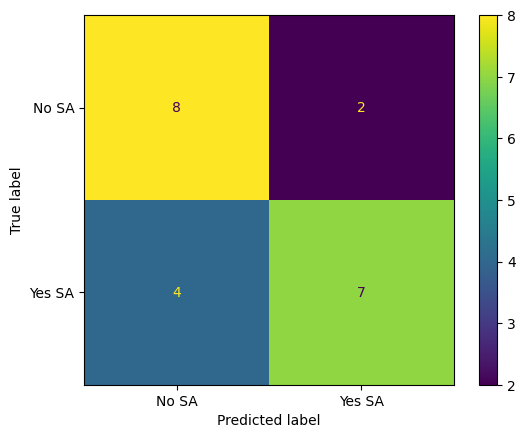

In [25]:
ConfusionMatrixDisplay.from_estimator(log_reg2, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

### Best mean: 0.000795, 0.000796, 0.000794

In [26]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                            penalty='l1', solver='liblinear',
                            C=0.000795)
log_reg3 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg3)
get_metrics(X_test, y_test, log_reg3)

              precision    recall  f1-score   support

           0       1.00      0.63      0.77      1293
           1       0.02      1.00      0.04         9

    accuracy                           0.63      1302
   macro avg       0.51      0.82      0.41      1302
weighted avg       0.99      0.63      0.77      1302

Accuracy: 0.6336
Recall: 1.0000
Sensitivity: 1.0000
Specificity: 0.6311
AUC: 0.9139
Average Precision: 0.0732
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.78      0.64      0.70        11

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.72      0.71      0.71        21

Accuracy: 0.7143
Recall: 0.6364
Sensitivity: 0.6364
Specificity: 0.8000
AUC: 0.7091
Average Precision: 0.7618


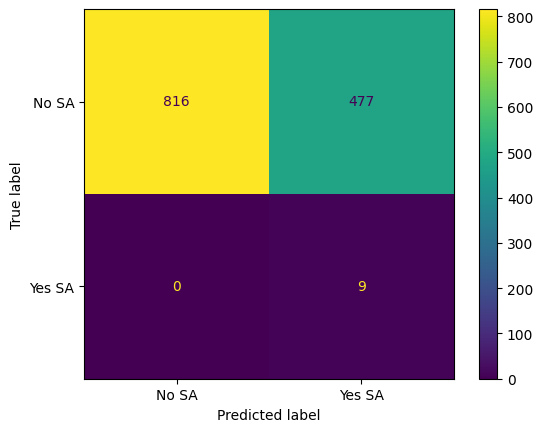

In [27]:
ConfusionMatrixDisplay.from_estimator(log_reg3, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

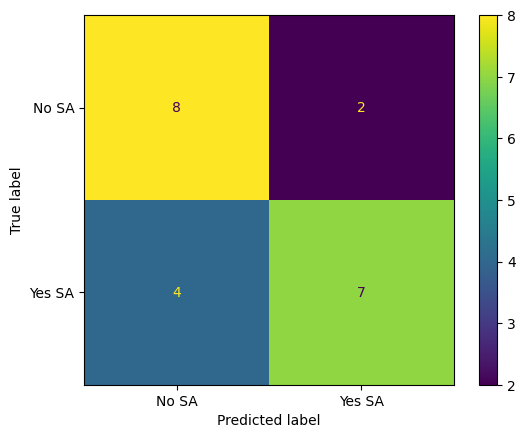

In [28]:
ConfusionMatrixDisplay.from_estimator(log_reg3, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

## **0.002025 vs 0.000795**


*   auc_test + auprc: 0.002025 b/c auc_test, auprc, and recall are the same, but auc_valid was the highest
*   recall: 0.000796 b/c recall was the same, but all other scores were the highest
*   mean: 0.000795 b/c auc_test, auprc, and recall are the same, but auc_valid was the highest



### **0.002025**

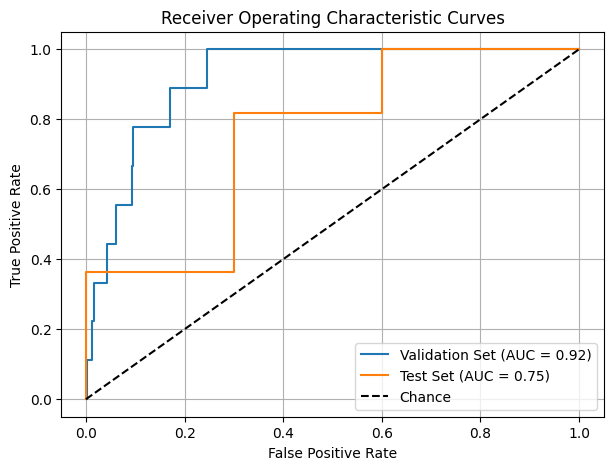

In [29]:
predict_proba_v = log_reg1.predict_proba(X_valid)
predict_proba_t = log_reg1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc1 = auc(fpr1, tpr1)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr1, tpr1, label=f'Test Set (AUC = {auc1:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

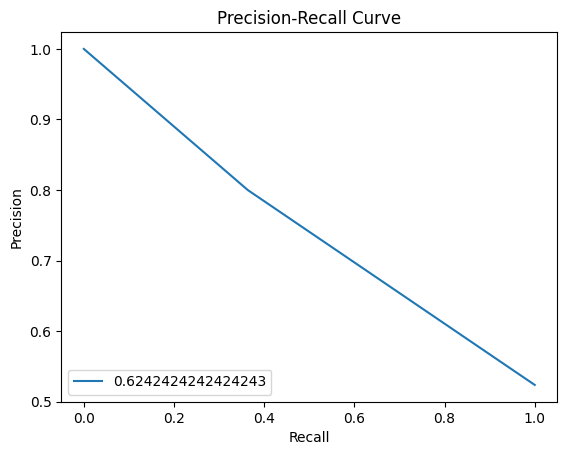

In [30]:
y_pred = log_reg1.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label=average_precision_score(y_test, y_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [31]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg1.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance.head(5)

,Feature,Coefficient,Odds Ratio
105,Internal.and.External.Comobidity,0.316909,1.372877
128,PPSP_frequency,0.167316,1.182128
86,WithDep.CBCL,0.128737,1.137391
109,Ne_PN,0.081622,1.085046
129,PPSP_distress,0.078739,1.081922


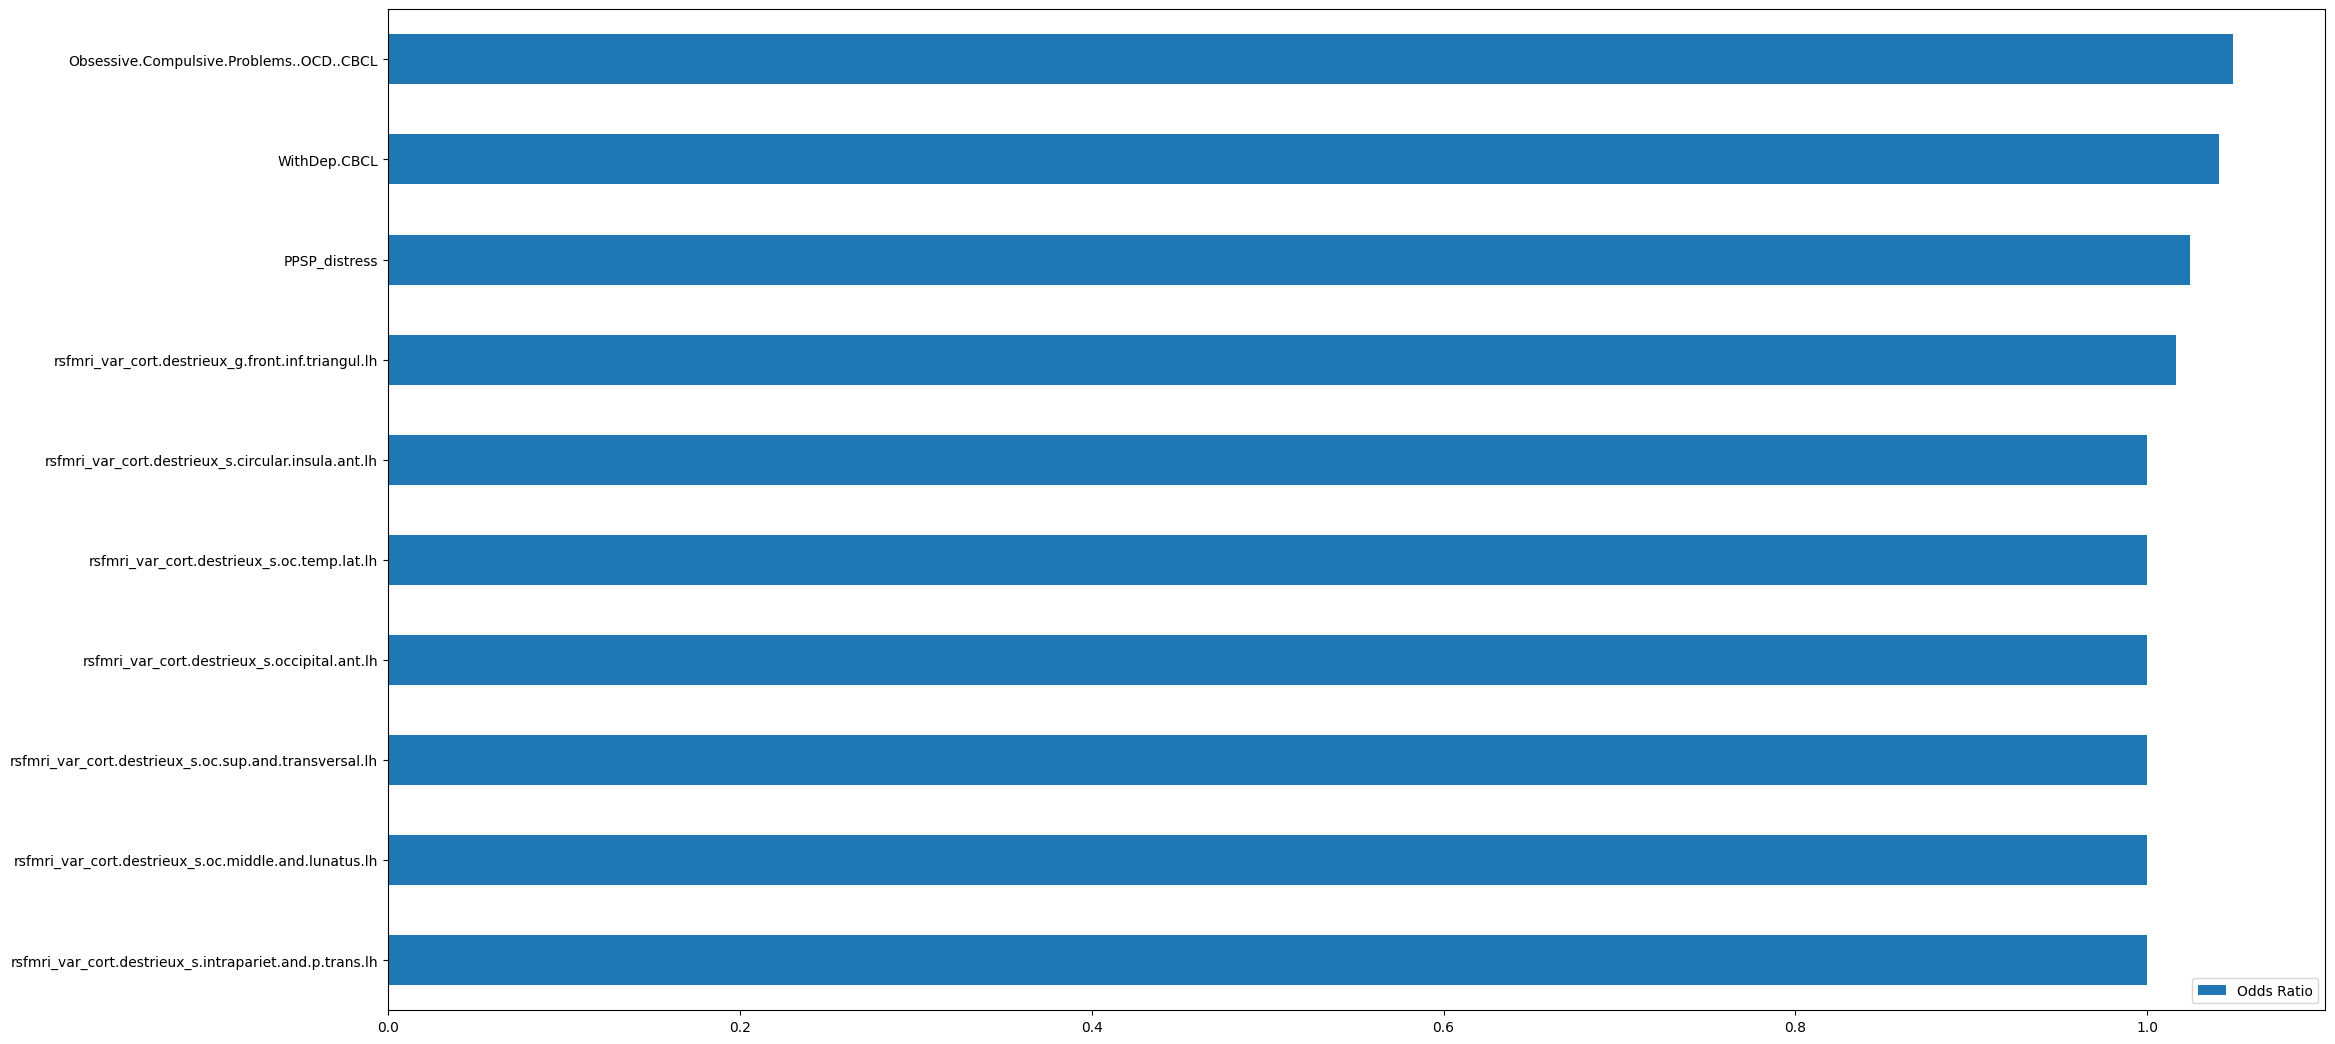

In [37]:
feature_odds = pd.DataFrame(odds_ratios, index=feature_names,
                            columns=['Odds Ratio'])
feature_odds = feature_odds.sort_values(by='Odds Ratio', ascending=False)
FI_plot = feature_odds.head(10).plot(figsize=(25,13), kind='barh').invert_yaxis()

### **0.000795**

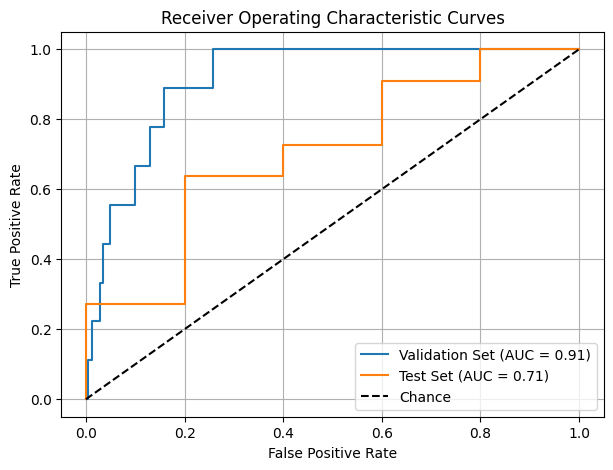

In [33]:
predict_proba_v = log_reg3.predict_proba(X_valid)
predict_proba_t = log_reg3.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc3 = auc(fpr3, tpr3)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr3, tpr3, label=f'Test Set (AUC = {auc3:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

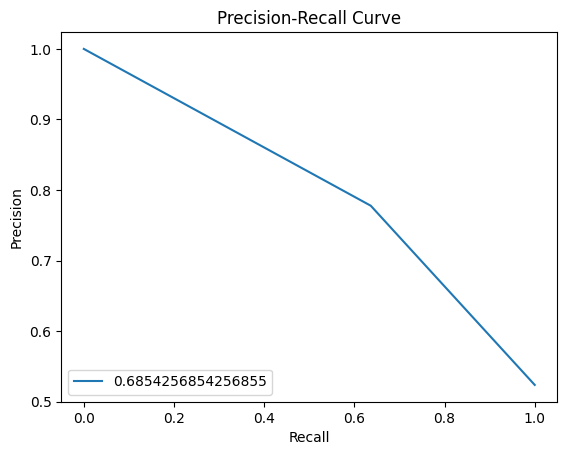

In [34]:
y_pred = log_reg3.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label=average_precision_score(y_test, y_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [35]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg3.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance.head(5)

,Feature,Coefficient,Odds Ratio
103,Obsessive.Compulsive.Problems..OCD..CBCL,0.047551,1.048699
86,WithDep.CBCL,0.039831,1.040635
129,PPSP_distress,0.023780,1.024065
143,rsfmri_var_cort.destrieux_g.front.inf.triangul.lh,0.016038,1.016167
176,rsfmri_var_cort.destrieux_s.circular.insula.an...,0.000000,1.000000


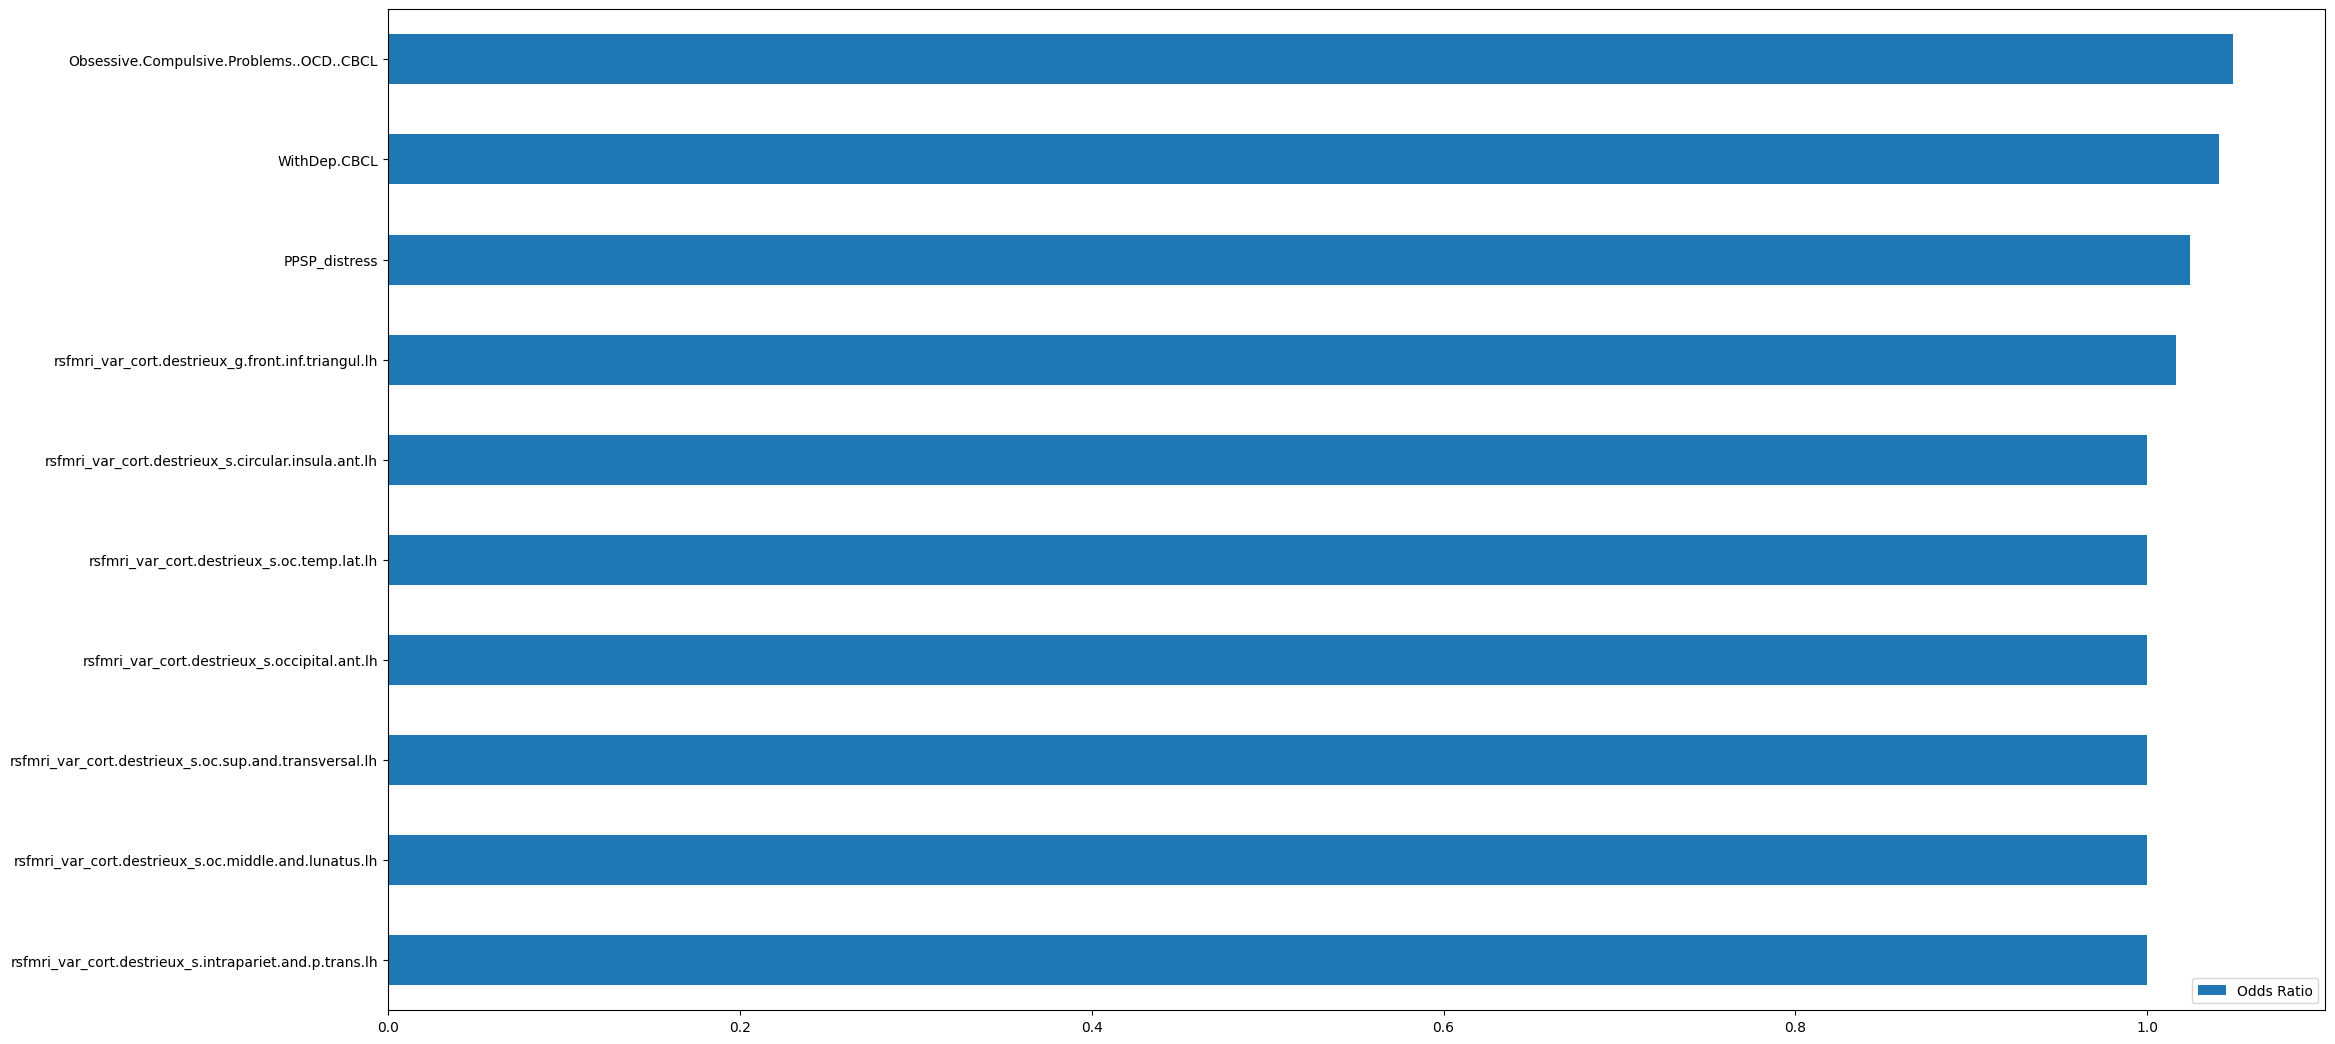

In [38]:
feature_odds = pd.DataFrame(odds_ratios, index=feature_names,
                            columns=['Odds Ratio'])
feature_odds = feature_odds.sort_values(by='Odds Ratio', ascending=False)
FI_plot = feature_odds.head(10).plot(figsize=(25,13), kind='barh').invert_yaxis()

## **ROC Comparison**

Although c = 0.002025 achieved a higher auc, c = 0.000795 has a higher recall and is more likely to assign a true positive, making c = 0.000795 the optimal choice.

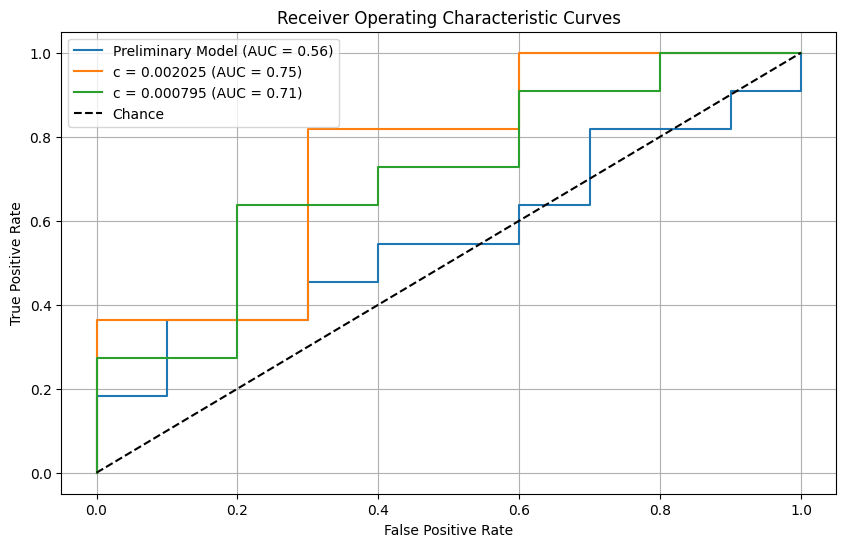

In [ ]:
auc_list = []
store_auc(X_test, y_test, 'Preliminary Model', log_reg_pre)
store_auc(X_test, y_test, 'c = 0.002025', log_reg1)
store_auc(X_test, y_test, 'c = 0.000795', log_reg3)
auc_compare_plot(auc_list)

## **Trial Conclusion: c = 0.000795**